## Exercise 3
Start with the lattice from Exercise 2 and modify it so you can correct the chromaticity for both planes to
zero. 

Try first to calculate approximately the required strengths. Implement your correction scheme in
your previous MAD-X files and verify your calculation. 

Use MAD-X to compute the exact strengths required
by matching the global parameters Q' and Q' (in MAD-X names: DQ1 and DQ2). Compare the results
with your calculations.

## Computations

Let us start assuming simple on-momentum tune shift and considering two Q-trim quadrupole in $s_1$ and $s_2$. Then the linear response of tune correction $(\Delta Q_x,~\Delta Q_y)^T$ with respect to quadrupole integrated gradients $(k1l(s_1),~k1l(s_2))^T$ is 

\begin{equation}
\begin{pmatrix}
\Delta Q_x \\ 
\Delta Q_y
\end{pmatrix}=\underbrace{\frac{1}{4\pi}
\begin{pmatrix}
\beta_x(s_1) & \beta_x(s_2)   \\ 
-\beta_y(s_1) & -\beta_y(s_2) 
\end{pmatrix}}_{M}
\begin{pmatrix}
k1l(s_1) \\ 
k1l(s_2)
\end{pmatrix}.
\end{equation}

Remembering that sextupole acts as quadrupoles on the dispersive closed orbit (feed-down) and assuming
that we have two sextupoles in $s_1$ and $s_2$,  then the linear response of chromaticity $(\Delta\xi_x,~\Delta\xi_y)^T$ with respect to the sextupoles integrated gradients $(k2l(s_1),~k2l(s_2))^T$ is 

\begin{equation}
\begin{pmatrix}
\Delta\xi_x \\ 
\Delta\xi_y
\end{pmatrix}=\underbrace{\frac{1}{4\pi}
\begin{pmatrix}
\beta_x(s_1) D_x(s_1) & \beta_x(s_2) D_x(s_2)  \\ 
-\beta_y(s_1) D_x(s_1) & -\beta_y(s_2) D_x(s_2)
\end{pmatrix}}_{M}
\begin{pmatrix}
k2l(s_1) \\ 
k2l(s_2)
\end{pmatrix}.
\end{equation}

We can determine the value of $(k2l(s_1),~k2l(s_2))^T$ by inverting this problem after having chosed $s_1$ and $s_2$.

In [29]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display
import matplotlib.patches as patches

def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5,lw=3):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

Please pay attention (below) to the use of the **interpolate**.

In [1]:
madx = Madx()
madx.input('''
TITLE, ’CAS2019 Third  Exercise’; 

circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl={2.0*pi/(4*ncell)};

!define quadrupoles as multipoles 
qf: multipole,knl:={0,0.0098*lq+qtrim_f}; 
qd: multipole,knl:={0,-0.0098*lq+qtrim_d};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
cas3: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
Beam, particle = proton, sequence=cas3, energy = 20.0;

use, sequence=cas3;

!!!!! very interesting option !!!!!
select,flag=interpolate, class=drift, slice=5, range=#s/#e;

ksf=0;
ksd=0;
twiss;
''')

NameError: name 'Madx' is not defined

(-5, 150)

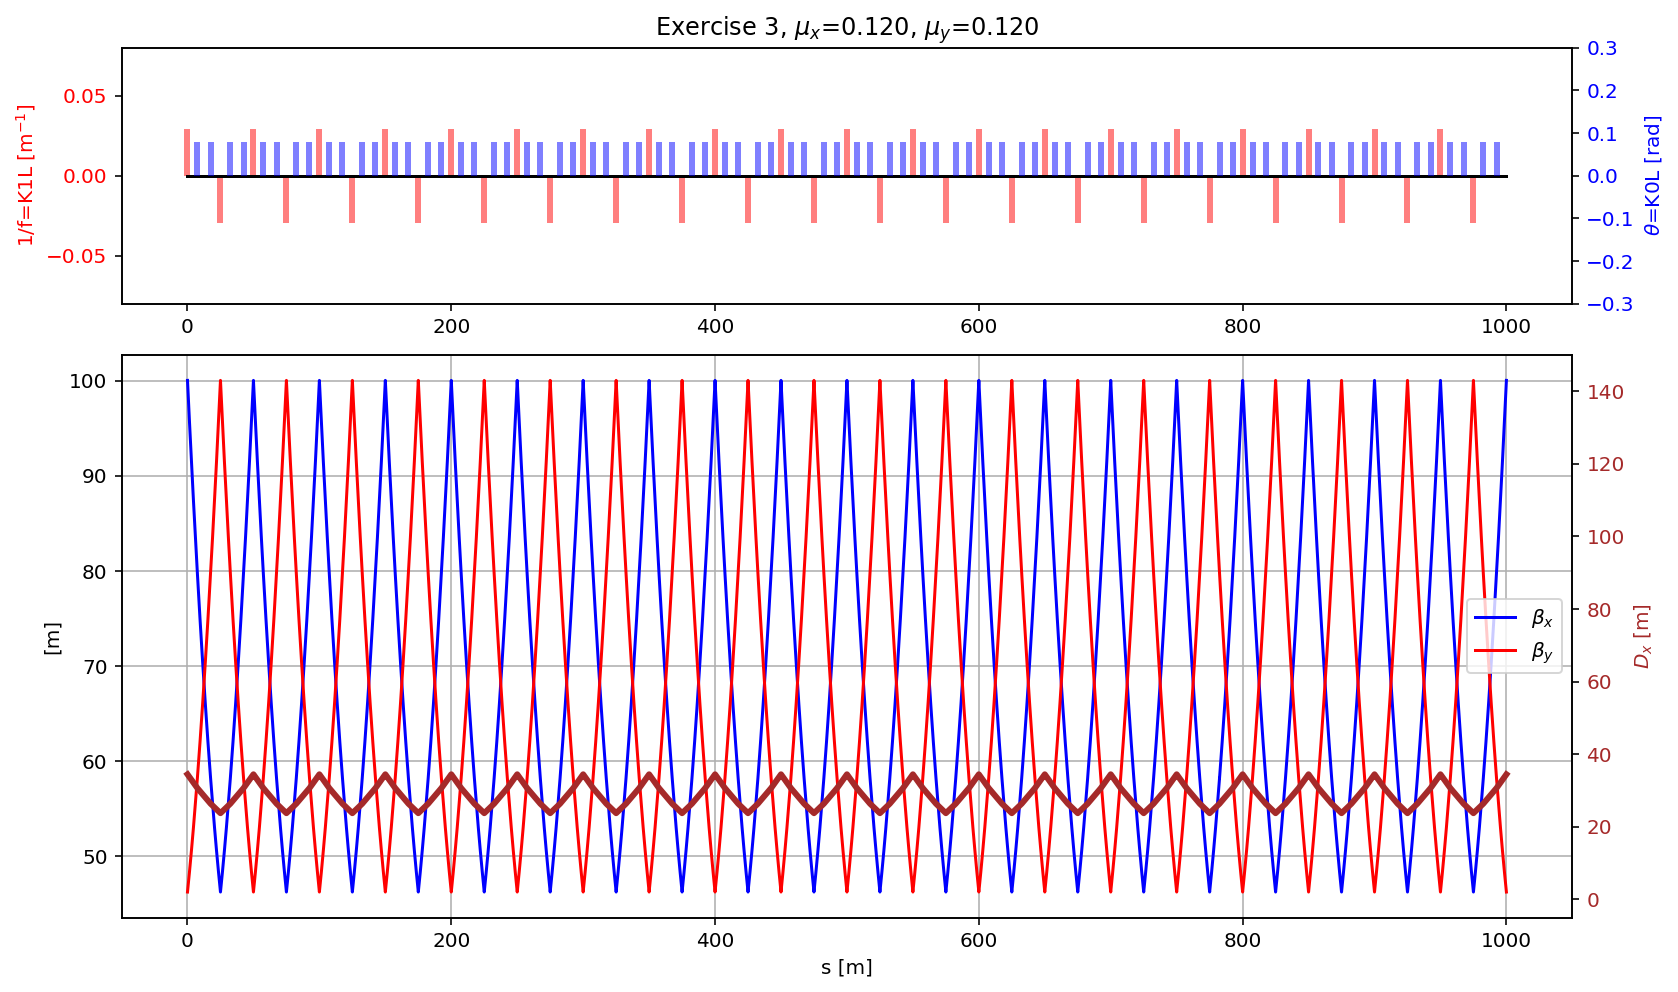

In [31]:
myTwiss=madx.table.twiss.dframe()
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Exercise 3, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 150)

If we assume to place the sextupole close to QF and at QD we have 

In [32]:
import numpy as np
twissSextupolesOFF=madx.table.twiss.dframe()
dq1=madx.table.summ.dq1[0]
dq2=madx.table.summ.dq2[0]
aux=twissSextupolesOFF[twissSextupolesOFF['name']=='qf:1']
bx1=aux['betx'].values[0]
by1=aux['bety'].values[0]
dx1=aux['dx'].values[0]

aux=twissSextupolesOFF[twissSextupolesOFF['name']=='qd:1']
bx2=aux['betx'].values[0]
by2=aux['bety'].values[0]
dx2=aux['dx'].values[0]

####### Solution of the linear problem #######
M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
mySolution=np.linalg.inv(M)@np.array([[-dq1],[-dq2]])
print('=======================================')
print('This is the solution our matrix of the\nintegrated sextupoles strength:')
display(mySolution)
print('=======================================')
# Clearly it has to be divided (shared) by the number of the cells

This is the solution our matrix of the
integrated sextupoles strength:


array([[ 0.01708331],
       [-0.02477473]])

In [33]:
# use the 'f-formatting' of python (thanks for the suggestions!)
madx.input(f'''
! FROM the analytical approach
ksf={mySolution[0][0]}/ncell;
ksd={mySolution[1][0]}/ncell;
twiss;
''');

++++++ info: ksf redefined
++++++ info: ksd redefined
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0       0.1789932276        2.363642011 

                q1                dq1            betxmax              dxmax 
       2.395724244   -1.511030458e-06        100.0267292        34.45748962 

             dxrms             xcomax             xcorms                 q2 
       29.10359317                  0                  0        2.395724244 

               dq2            betymax              dymax              dyrms 
  -5.036768634e-07        100.0267292                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                 

In [34]:
print('=======================================')
print('After applying the analytical solution')
print(f'DQ1={madx.table.summ.dq1[0]}')
print(f'DQ2={madx.table.summ.dq2[0]}')
print('=======================================')

After applying the analytical solution
DQ1=-1.5110304583292177e-06
DQ2=-5.036768634261591e-07


In [35]:
# Is the MAD-X matching going to be better
madx.input('''
! Matching
match, sequence=cas3;
  vary,name=ksf, step=0.00001;
  vary,name=ksd, step=0.00001;
  global,DQ1=0.0;
  global,DQ2=0.0;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;

!execute the TWISS command 
twiss;
survey;''')

START MATCHING

number of sequences: 1
sequence name: cas3
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   5.28142087e-30





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
ksf                       8.54166e-04  8.54166e-04 -1.00000e+20  1.00000e+20
ksd                      -1.23874e-03 -1.23874e-03 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   5.28142087e-30
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0       0.1789932276        2.363642011 

                q1       

True

In [36]:
print('=======================================')
print('After applying the MAD-X matching')
print(f'DQ1={madx.table.summ.dq1[0]}')
print(f'DQ2={madx.table.summ.dq2[0]}')
print('=======================================')

After applying the MAD-X matching
DQ1=-2.261987337050167e-15
DQ2=4.0599772716285e-16


### Why MAD-X is more precise than our solutions? Any ideas?
HINT (it is more than an hint): does the assumend $\beta$-function include the off-momentum $\beta$-beating?

### Are the chosen sextupole positions optimal? 
To answer this question we can approach it in different directions.
We can consider to move the positions of the sextupoles (s1 and s2) and solve the system again. What we would like to minimize is the $max(abs([k2l(s1), k2l(s1)]))$ for this particular correction.

In [37]:
# Loops in the positions 
myS=np.unique(twissSextupolesOFF['s'])
myS=myS[myS<=50] # 50 is the length of the cell in our case
mySolutions=[]
s1=[]
s2=[]
for i in myS:
    for j in myS:
        aux=twissSextupolesOFF[twissSextupolesOFF['s']==i]
        bx1=aux['betx'].values[0]
        by1=aux['bety'].values[0]
        dx1=aux['dx'].values[0]
        aux=twissSextupolesOFF[twissSextupolesOFF['s']==j]
        bx2=aux['betx'].values[0]
        by2=aux['bety'].values[0]
        dx2=aux['dx'].values[0]
        M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
        if np.abs(np.linalg.det(M))>1e-10:
            mySolutions.append(np.max(np.abs(np.linalg.inv(M)@np.array([[-dq1],[-dq2]]))))
            s1.append(i)
            s2.append(j)

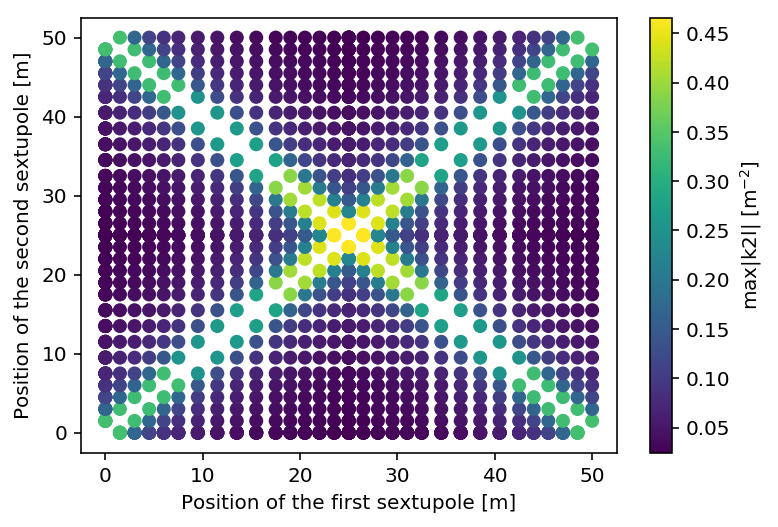

In [38]:
# Plotting the results
aux=np.array(mySolutions)
aux0=aux[aux<0.5]
aux1=np.array(s1)
aux2=np.array(s2)
plt.scatter(aux1[aux<0.5],aux2[aux<0.5], c=aux0)
plt.xlabel('Position of the first sextupole [m]')
plt.ylabel('Position of the second sextupole [m]')

myColorbar=plt.colorbar()
myColorbar.set_label('max|k2l| [m$^{-2}$]')

The positions on the diagonal and anti-diagonal of the previous plot give singular matrices.
As expected the best soution is to install the two sextupoles close to the F and D quadrupoles.

An alternative strategy to analyze this optimization problem, is to consider the condition number of the matrix as our main observable (replacing the $max(abs([k2l(s1), k2l(s1)]))$ ). 

In [39]:
# To learn about the 'cond' function
np.linalg.cond?

Signature: np.linalg.cond(x, p=None)
Docstring:
Compute the condition number of a matrix.

This function is capable of returning the condition number using
one of seven different norms, depending on the value of `p` (see
Parameters below).

Parameters
----------
x : (..., M, N) array_like
    The matrix whose condition number is sought.
p : {None, 1, -1, 2, -2, inf, -inf, 'fro'}, optional
    Order of the norm:

    =====  ============================
    p      norm for matrices
    =====  ============================
    None   2-norm, computed directly using the ``SVD``
    'fro'  Frobenius norm
    inf    max(sum(abs(x), axis=1))
    -inf   min(sum(abs(x), axis=1))
    1      max(sum(abs(x), axis=0))
    -1     min(sum(abs(x), axis=0))
    2      2-norm (largest sing. value)
    -2     smallest singular value
    =====  ============================

    inf means the numpy.inf object, and the Frobenius norm is
    the root-of-sum-of-squares norm.

Returns
-------
c : {float, inf}
 

In [40]:
# Loops in the positions 
myS=np.unique(twissSextupolesOFF['s'])
myS=myS[myS<=50] # 50 is the length of the cell in our case
mySolutionsConditioning=[]
s1Conditioning=[]
s2Conditioning=[]
for i in myS:
    for j in myS:
        aux=twissSextupolesOFF[twissSextupolesOFF['s']==i]
        bx1=aux['betx'].values[0]
        by1=aux['bety'].values[0]
        dx1=aux['dx'].values[0]
        aux=twissSextupolesOFF[twissSextupolesOFF['s']==j]
        bx2=aux['betx'].values[0]
        by2=aux['bety'].values[0]
        dx2=aux['dx'].values[0]
        M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
        mySolutionsConditioning.append(np.linalg.cond(M))
        s1Conditioning.append(i)
        s2Conditioning.append(j)

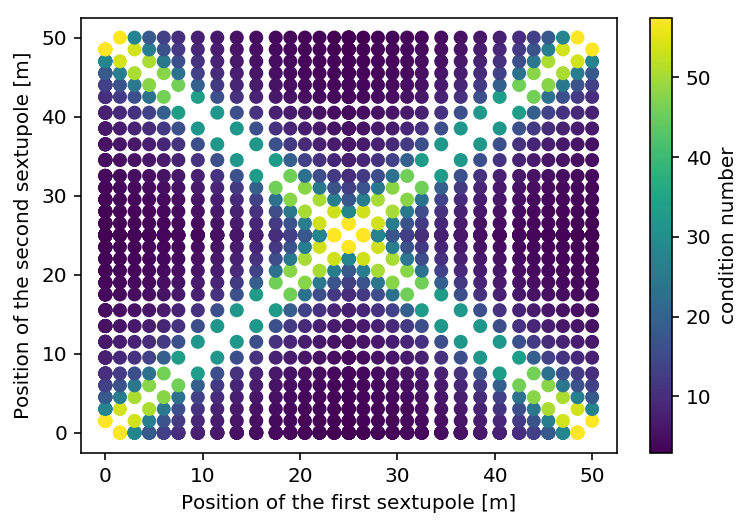

In [41]:
# Plotting the results
aux=np.array(mySolutionsConditioning)
myLimit=100
aux0=aux[aux<myLimit]
aux1=np.array(s1Conditioning)
aux2=np.array(s2Conditioning)
plt.scatter(aux1[aux<myLimit],aux2[aux<myLimit], c=aux0)
plt.xlabel('Position of the first sextupole [m]')
plt.ylabel('Position of the second sextupole [m]')

myColorbar=plt.colorbar()
myColorbar.set_label('condition number')

As expected, the conclusion is exaclty equivalent. 

#### Given that the maximum integrated strength of the sextupoles is $0.05/n_{cell}~m^{-2}$ (each sextupole has a bi-polar power supply) what is the *reacheable* domain of ($\Delta\xi_x$,$\Delta\xi_y$)? 

A simple (effective but  inelegant) way to answer to this question is to consider a naive Montecarlo spanning all combinations of sextupoles strengths and looking to the results in the chromaticity plane.

In [42]:
import numpy as np
twissSextupolesOFF=madx.table.twiss.dframe()
dq1=madx.table.summ.dq1[0]
dq2=madx.table.summ.dq2[0]
aux=twissSextupolesOFF[twissSextupolesOFF['name']=='qf:1']
bx1=aux['betx'].values[0]
by1=aux['bety'].values[0]
dx1=aux['dx'].values[0]

aux=twissSextupolesOFF[twissSextupolesOFF['name']=='qd:1']
bx2=aux['betx'].values[0]
by2=aux['bety'].values[0]
dx2=aux['dx'].values[0]
M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi

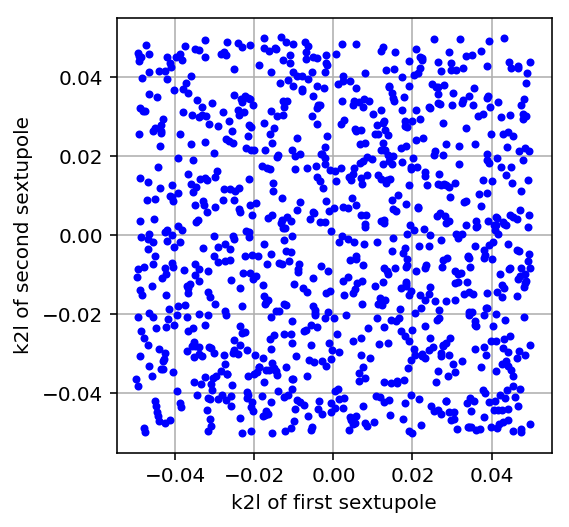

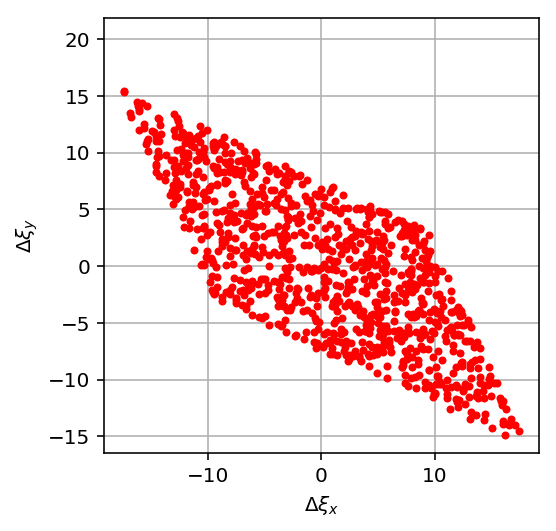

In [43]:
N=1000
myRandomX=(np.random.rand(2,N)-.5)*2*0.05
myFig1=plt.figure()
plt.plot(myRandomX[0,:],myRandomX[1,:],'.b')
plt.axis('equal');
plt.axis('square');
plt.xlabel('k2l of first sextupole')
plt.ylabel('k2l of second sextupole')
plt.grid()

myFig2=plt.figure()
myRandomY=M@myRandomX
plt.plot(myRandomY[0,:],myRandomY[1,:],'.r')
plt.axis('equal');
plt.axis('square');
plt.xlabel('$\Delta\\xi_x$')
plt.ylabel('$\Delta\\xi_y$')
plt.grid()


Though inelegant, the result suggests the alternative approach: we need in fact to transform only two vectors (in black in the following plot) to compute the effect on the chromaticity plane (parallelogram generated by the transformed vectors, in black in the following plot).

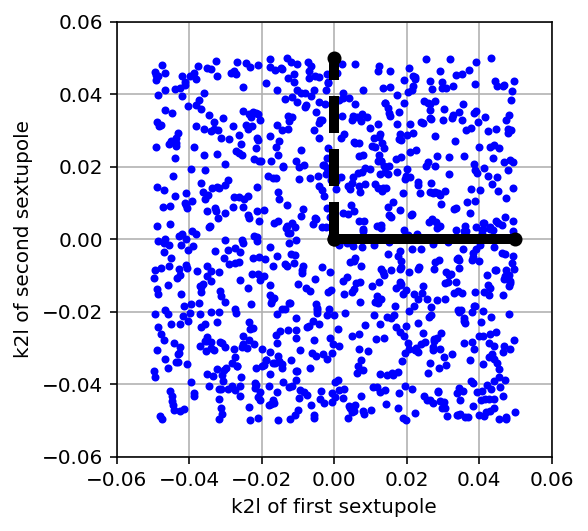

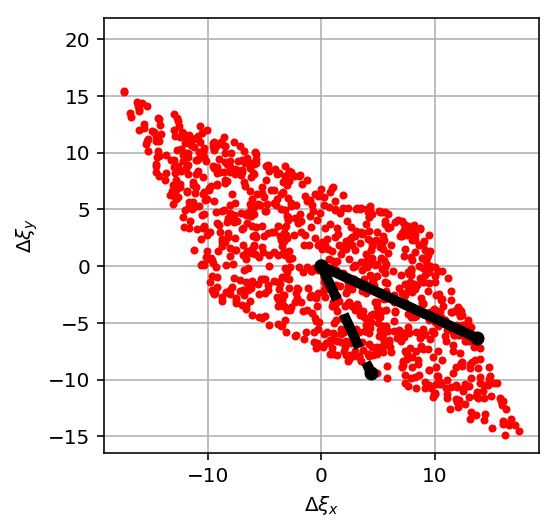

In [44]:
N=1000
myX=np.array([[0.05,0],[0,0.05]])
plt.plot(myRandomX[0,:],myRandomX[1,:],'.b')
plt.axis('equal');
plt.axis('square');
plt.plot([0,myX[0,0]],[0,myX[0,1]],'k-o', lw=5)
plt.plot([0,myX[1,0]],[0,myX[1,1]],'k--o', lw=5)
plt.xlim(-0.06,0.06)
plt.ylim(-0.06,0.06)
plt.xlabel('k2l of first sextupole')
plt.ylabel('k2l of second sextupole')
plt.grid()

plt.figure()
myRandomY=M@myRandomX
plt.plot(myRandomY[0,:],myRandomY[1,:],'.r')

myY=M@myX

plt.plot([0,myY[0,0]],[0,myY[1,0]],'k-o', lw=5)
plt.plot([0,myY[0,1]],[0,myY[1,1]],'k--o', lw=5)

plt.axis('equal');
plt.axis('square');
plt.xlabel('$\Delta\\xi_x$')
plt.ylabel('$\Delta\\xi_y$')
plt.grid()

### Tune knobs
An approach similar to the one used for the chromaticity correction can be adopted for the tune correction.
In the sequence, we define already the variables we will use for the corrections (qtrim_f, qtrim_d).

After having computed (using MAD-X) the response of the qtrim_f and qtrim_d, using the matrix relation described to the introduction and not with MAD-X, compute $\beta$-function at the F/D quadrupoles. Compare with MAD-X.

In [45]:
madx.input(f'qtrim_f=0; qtrim_d=0; twiss;')
Q1_ref=madx.table.summ.q1[0]
Q2_ref=madx.table.summ.q2[0]

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0       0.1789932276        2.363642011 

                q1                dq1            betxmax              dxmax 
       2.395724244   -2.261987337e-15        100.0267292        34.45748962 

             dxrms             xcomax             xcorms                 q2 
       29.10359317                  0                  0        2.395724244 

               dq2            betymax              dymax              dyrms 
   4.059977272e-16        100.0267292                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [49]:
qtrim_f=0.00000001;
madx.input(f'qtrim_f={qtrim_f}; twiss; qtrim_f=0;')
deltaQ1_f=madx.table.summ.q1[0]-Q1_ref
deltaQ2_f=madx.table.summ.q2[0]-Q2_ref

++++++ info: qtrim_f redefined
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0       0.1789929906        2.363643575 

                q1                dq1            betxmax              dxmax 
       2.395725836    -4.61524281e-06        100.0266758          34.457446 

             dxrms             xcomax             xcorms                 q2 
       29.10355516                  0                  0        2.395723507 

               dq2            betymax              dymax              dyrms 
  -2.809091889e-06         100.026763                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 


In [50]:
qtrim_d=qtrim_f;
madx.input(f'qtrim_d={qtrim_d}; twiss;qtrim_d=0;')
deltaQ1_d=madx.table.summ.q1[0]-Q1_ref
deltaQ2_d=madx.table.summ.q2[0]-Q2_ref

++++++ info: qtrim_d redefined
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0       0.1789931149        2.363642754 

                q1                dq1            betxmax              dxmax 
        2.39572498   -2.458797139e-06        100.0266953        34.45746762 

             dxrms             xcomax             xcorms                 q2 
       29.10357496                  0                  0        2.395722652 

               dq2            betymax              dymax              dyrms 
   2.338815127e-07        100.0267826                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 


In [51]:
M_Qtrim=np.array([[deltaQ1_f, deltaQ1_d],[deltaQ2_f, deltaQ2_d]])/qtrim_f/20
M_Qtrim*np.pi*4

array([[ 100.02670237,   46.26464245],
       [ -46.2646535 , -100.02675586]])

The previous equation has to be compared with the matrix
\begin{equation}
\begin{pmatrix}
\beta_x(s_1) & \beta_x(s_2)   \\ 
-\beta_y(s_1) & -\beta_y(s_2) 
\end{pmatrix}
\end{equation}

This is an example of k-modulation measurement in MAD-X. Why there is a residual error? (No hint this time).

### Can you extract the first order matrix of the lattice? and the second order maps?
Yes. See the **sectormap** command 
http://madx.web.cern.ch/madx/webguide/manual.html#Ch29

In [52]:
madx.input('select,flag=interpolate,clear;twiss,sectormap;')

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0       0.1789932276        2.363642011 

                q1                dq1            betxmax              dxmax 
       2.395724244   -2.261987337e-15        100.0267292        34.45748962 

             dxrms             xcomax             xcorms                 q2 
       29.17402574                  0                  0        2.395724244 

               dq2            betymax              dymax              dyrms 
   4.059977272e-16        100.0267292                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

True

In [53]:
list(madx.table)

['summ', 'twiss', 'survey', 'sectortable']

In [54]:
sectormapDF=madx.table.sectortable.dframe()
sectormapDF.head()

,name,pos,k1,k2,k3,k4,k5,k6,r11,r21,...,t356,t456,t556,t656,t166,t266,t366,t466,t566,t666
#s,cas3$start,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
start_machine,start_machine,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
qf,qf,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
drift_0[0],drift_0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.656129e-08,0.0
msf,msf,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0


In the previous dataframe you can see for the different elements the maps 
\begin{equation}
\boxed{
x_i(s_1)=\underbrace{k_i}_{0-order}+ \underbrace{\sum_j r_{ij}\ x_j(s_0)}_{1-order} + \underbrace{\sum_j\sum_k t_{ijk}\ x_j(s_0)x_k(s_0)}_{2-order}
}
\end{equation}
where $k_i$,$r_{ij}$ and $t_{ijk}$ can be found in the **sectormap** dataframe. The $x_i$ are the 6 phase coordinates (in MAD-D are (x,px,y,py,t,pt)) in $s_0$ and $s_1$ .

In [55]:
sectormapDF[sectormapDF.index=='qf'].transpose().head(44)

,qf
name,qf
pos,0
k1,0
k2,0
k3,0
k4,0
k5,0
k6,0
r11,1
r21,-0.0294


In [56]:
# all the t_{ijk} are vanishing
np.sum(np.abs(sectormapDF[sectormapDF.index=='qf'].transpose().iloc[44:]))

qf    0.0
dtype: float64